In [46]:
from ValueIteration import value_iteration
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
import pandas as pd

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.title_fontsize'] = 14
plt.rcParams['legend.fontsize'] = 14

# Implementing Value Iteration to solve 3-echelon inventory optimisation MDPs

## Centralised system

### No lead times

#### Set up data structures

In [47]:
# Function to create state space
def create_state_space(capacity, increment, n_ech=2):
    ''' Creates a set as the state space for an n-echelon problem 
    with format (x1, ..., xn) where xj is the inventory level at site j '''

    # Possible inventory levels at each site
    IL = set(int(x) for x in np.arange(-capacity, capacity+1, increment))

    # Possible set of sets
    S = sorted(set(il_pair for il_pair in itertools.product(IL, repeat=n_ech) if il_pair[1] >= 0))

    # Dictionary containing indices for each state (for value iteration)
    state_idx = {s: i for i, s in enumerate(S)}
    
    return S, state_idx

def create_action_space(capacity, increment, n_ech=2):
    ''' Creates a set as the action space for an n-echelon inventory problem
    with format (q1, ..., qn) where qj is the quantity ordered by site j 
    from site j+1 '''

    # The maximum order quantity at each site is half the capacity of the site
    order_set = set(int(x) for x in np.arange(0, math.ceil(capacity/2)+1, increment))
    
    # Possible actions
    A = sorted(set(order_pair for order_pair in itertools.product(order_set, repeat=n_ech)))

    # Dictionary containing indices for each action (for value iteration)
    action_idx = {a: i for i, a in enumerate(A)}

    return A, action_idx



def create_P_c0(S, A, state_idx, action_idx, demand_distribution, capacity):
    ''' 
    Creates an array containing transition probabilities from s to s' under a
    for a centralised multi-echelon serial system without lead times 
    '''

    def prob_trans(s, a, sp):
        ''' Calculates transition probability from s to s' under action a'''
        prob = 0

        # check next inventory level for warehouse
        s_next_W = s[1] + a[1] - a[0] # default next state value
        if s_next_W != sp[1]: # inventory transition at W
            return prob
        
        if a[0] > s[1]: # check whether DC to W order constraint is violated
            return prob
        
        # check next inventory level for DC
        for d in demand_distribution.keys():
            s_next_DC = s[0] + a[0] - d
            if - capacity < s_next_DC < capacity: # non truncated state
                if sp == (s_next_DC, s_next_W):
                    prob = demand_distribution.get(d, 0)
                    return prob

            elif s_next_DC >= capacity: # truncated state above capacity
                if sp == (capacity, s_next_W):
                    prob = sum(demand_distribution[dem] for dem in demand_distribution if s[0] + a[0] - dem >= capacity)
                    return prob
                
            elif s_next_DC <= -capacity: # truncated state below backlog limit
                if sp == (-capacity, s_next_W):
                    prob = sum(demand_distribution[dem] for dem in demand_distribution if s[0] + a[0] - dem <= -capacity)
                    return prob
            
        return prob
    
    # array to store transition probabilities for all combinations of s, a, s'
    P_array = np.zeros((len(S), len(A), len(S)))

    for s in S: # for each state s
        s_idx = state_idx[s]
        for a in A: # for each action a
            a_idx = action_idx[a]
            for sp in S: # for each new state s'
                sp_idx = state_idx[sp]
                # calculate and store probability of transitioning to s' from s under a
                P_array[s_idx, a_idx, sp_idx] = prob_trans(s, a, sp) 
    
    return P_array



        
def create_R_c0(S, A, state_idx, action_idx, demand_distribution, hold_costs, backlog_cost):
    ''' 
    Creates an array containing reward obtained under action a chosen at 
    state s for a centralised multi-echelon serial system without lead times.
    '''

    def cost_function(s, a):
        ''' Calculates the cost incurred if action a is taken at state s. '''
        # Costs at warehouse: holding cost (hc)
        hc_w = hold_costs[1]*max(s[1] + a[1] - a[0], 0)
        warehouse_cost = hc_w

        # Costs at DC: holding cost (hc) and backlog cost (bc)
        hc_dc = hold_costs[0]*sum(max(s[0] + a[0] - dt, 0)*prob for dt, prob in demand_distribution.items())
        bc_dc = backlog_cost*sum(max(dt - s[0] - a[0], 0)*prob for dt, prob in demand_distribution.items())
        dc_cost = hc_dc + bc_dc

        return warehouse_cost + dc_cost
    
    R_array = np.zeros((len(S), len(A)))

    for s in S: # for each state s
        s_idx = state_idx[s]
        for a in A: # for each action a
            a_idx = action_idx[a]
            R_array[s_idx, a_idx] = cost_function(s, a) # calculate reward for taking action a at state s

    return R_array



def c0_value_update_func(state_idx, action_idx, capacity):
    def bellman_eq_2c0(s, S, A, P, R, gamma, Vk):
        ''' Calculates the values from taking each action at state s '''
        s_idx = state_idx[s]
        # ordering decisions should ensure that site capacity is not exceeded and DC orders at most on-hand stock of warehouse
        values = dict((a, 0) for a in A if s[0]+a[0] <= capacity and s[1]+a[1] <= capacity and a[0] <= s[1])
        # print("s:", s, "possible orders:", values.keys())
        if not values: # if there are no possible ordering decisions, then no units need to be ordered
            values = {(0, 0): 0}
        
        for a in values.keys():
            a_idx = action_idx[a]
            values[a] = R[s_idx, a_idx] + gamma*sum([P[s_idx, a_idx, state_idx[sp]]*Vk[sp] for sp in S])
        return values
    
    return bellman_eq_2c0


#### Solve the Problem

In [48]:
# Solving the centralised 3-echelon MDP
capacity = 1000
increment = 100

S, state_idx = create_state_space(capacity, increment)        # state space
A, action_idx = create_action_space(capacity, increment)      # action space
demand_dist = {0: 0.2, 100: 0.6, 200: 0.2}                    # retailer demand distribution
h = [1, 0.5]                                                  # holding cost at DC, W
cb = 50                                                       # backlog penalty cost at DC
P = create_P_c0(S, A, state_idx, action_idx, demand_dist, capacity)
R = create_R_c0(S, A, state_idx, action_idx, demand_dist, hold_costs=h, backlog_cost=cb)
V_init = dict([(s, 0) for s in S])
gamma = 0.999
bellman_eq_c0 = c0_value_update_func(state_idx, action_idx, capacity)

# Run and store results from value iteration
c0_results = value_iteration(S, A, P, R, gamma, max_iterations=1000, 
                             bellman_eq=bellman_eq_c0, V_init=V_init, theta=1e-7)
c0_optimal_policy = c0_results["optimal_policy"]
c0_cost_function = c0_results["value_function"]



#### Generate Plots for optimal policy

### No lead times, without order constraint

In [49]:
# Function to create state space
def create_state_space_noc(capacity, increment, n_ech=2):
    ''' Creates a set as the state space for an n-echelon problem 
    with format (x1, ..., xn) where xj is the inventory level at site j '''

    # Possible inventory levels at each site
    IL = set(int(x) for x in np.arange(-capacity, capacity+1, increment))

    # Possible set of sets
    S = sorted(set(il_pair for il_pair in itertools.product(IL, repeat=n_ech)))

    # Dictionary containing indices for each state (for value iteration)
    state_idx = {s: i for i, s in enumerate(S)}
    
    return S, state_idx

def create_action_space_noc(capacity, increment, n_ech=2):
    ''' Creates a set as the action space for an n-echelon inventory problem
    with format (q1, ..., qn) where qj is the quantity ordered by site j 
    from site j+1 '''

    # The maximum order quantity at each site is half the capacity of the site
    order_set = set(int(x) for x in np.arange(0, math.ceil(capacity/2)+1, increment))
    
    # Possible actions
    A = sorted(set(order_pair for order_pair in itertools.product(order_set, repeat=n_ech)))

    # Dictionary containing indices for each action (for value iteration)
    action_idx = {a: i for i, a in enumerate(A)}

    return A, action_idx

def create_P_c0_noc(S, A, state_idx, action_idx, demand_distribution, capacity):
    ''' 
    Creates an array containing transition probabilities from s to s' under a
    for a centralised multi-echelon serial system without lead times 
    '''

    def prob_trans(s, a, sp):
        ''' Calculates transition probability from s to s' under action a'''
        prob = 0

        # check next inventory level for warehouse
        s_next_W = s[1] + a[1] - a[0] # default next state value
        if s_next_W > capacity: # truncated state above W capacity
            s_next_W = capacity

        elif s_next_W < -capacity: # truncated state below backlog limit
            s_next_W = -capacity
        
        

        
        # check next inventory level for DC
        for d in demand_distribution.keys():
            q_sent_to_DC = min(a[0]+max(-s[1], 0), a[1]+max(s[1], 0))
            s_next_DC = s[0] + q_sent_to_DC - d
            if - capacity < s_next_DC < capacity: # non truncated state
                if sp == (s_next_DC, s_next_W):
                    prob = demand_distribution.get(d, 0)
                    return prob

            elif s_next_DC >= capacity: # truncated state above capacity
                if sp == (capacity, s_next_W):
                    prob = sum(demand_distribution[dem] for dem in demand_distribution if s[0] + q_sent_to_DC - dem >= capacity)
                    return prob
                
            elif s_next_DC <= -capacity: # truncated state below backlog limit
                if sp == (-capacity, s_next_W):
                    prob = sum(demand_distribution[dem] for dem in demand_distribution if s[0] + q_sent_to_DC - dem <= -capacity)
                    return prob
            
        return prob
    
    # array to store transition probabilities for all combinations of s, a, s'
    P_array = np.zeros((len(S), len(A), len(S)))

    for s in S: # for each state s
        s_idx = state_idx[s]
        for a in A: # for each action a
            a_idx = action_idx[a]
            for sp in S: # for each new state s'
                sp_idx = state_idx[sp]
                # calculate and store probability of transitioning to s' from s under a
                P_array[s_idx, a_idx, sp_idx] = prob_trans(s, a, sp) 
    
    return P_array





def create_R_c0_noc(S, A, state_idx, action_idx, demand_distribution, hold_costs, backlog_costs):
    ''' 
    Creates an array containing reward obtained under action a chosen at 
    state s for a centralised multi-echelon serial system without lead times.
    '''

    def cost_function(s, a):
        ''' Calculates the cost incurred if action a is taken at state s. '''
        q_sent_to_dc = min(a[0]+max(-s[1], 0), a[1]+max(s[1], 0))

        # Costs at warehouse: holding cost (hc) and backlog cost (bc)
        hc_w = hold_costs[1]*max(s[1] + a[1] - a[0], 0)
        bc_w = backlog_costs[1]*max(a[0] - s[1] - a[1], 0)
        warehouse_cost = hc_w + bc_w

        # Costs at DC: holding cost (hc) and backlog cost (bc)
        hc_dc = hold_costs[0]*sum(max(s[0] + q_sent_to_dc - dt, 0)*prob for dt, prob in demand_distribution.items())
        bc_dc = backlog_costs[0]*sum(max(dt - s[0] - q_sent_to_dc, 0)*prob for dt, prob in demand_distribution.items())
        dc_cost = hc_dc + bc_dc

        return warehouse_cost + dc_cost
    
    R_array = np.zeros((len(S), len(A)))

    for s in S: # for each state s
        s_idx = state_idx[s]
        for a in A: # for each action a
            a_idx = action_idx[a]
            R_array[s_idx, a_idx] = cost_function(s, a) # calculate reward for taking action a at state s

    return R_array



def c0_noc_value_update_func(state_idx, action_idx, capacity):
    def bellman_eq_2c0(s, S, A, P, R, gamma, Vk):
        ''' Calculates the values from taking each action at state s '''
        s_idx = state_idx[s]
        # ordering decisions should ensure that site capacity is not exceeded and DC orders at most on-hand stock of warehouse
        values = dict((a, 0) for a in A if s[0]+a[0] <= capacity and s[1]+a[1] <= capacity)
        # print("s:", s, "possible orders:", values.keys())
        if not values: # if there are no possible ordering decisions, then no units need to be ordered
            values = {(0, 0): 0}
        
        for a in values.keys():
            a_idx = action_idx[a]
            values[a] = R[s_idx, a_idx] + gamma*sum([P[s_idx, a_idx, state_idx[sp]]*Vk[sp] for sp in S])
        return values
    
    return bellman_eq_2c0



In [50]:
# Solving the decentralised two-stage problem without order constraints between DC and warehouse
capacity = 1000                                               # warehouse and DC capacity
increment = 100                                               # discretisation increment for states
demand_dist = {0: 0.2, 100: 0.6, 200: 0.2}                    # retailer demand distribution
h = [1, 0.5]
cb = [50, 25]
gamma = 0.999

S, state_idx = create_state_space_noc(capacity, increment)
A, action_idx = create_action_space_noc(capacity, increment)
P = create_P_c0_noc(S, A, state_idx, action_idx, demand_dist, capacity)
R = create_R_c0_noc(S, A, state_idx, action_idx, demand_dist, h, cb)
bellman_eq_c0_noc = c0_noc_value_update_func(state_idx, action_idx, capacity)
V_init = dict([(s, 0) for s in S])

# Run and store results from value iteration
c0_noc_results = value_iteration(S, A, P, R, gamma, max_iterations=1000, 
                             bellman_eq=bellman_eq_c0_noc, V_init=V_init, theta=1e-7)
c0_noc_optimal_policy = c0_noc_results["optimal_policy"]
c0_noc_cost_function = c0_noc_results["value_function"]

## Decentralised system

### No lead times, with order constraint

#### Set up data structures

In [51]:
# Function to create state space
def create_dc0_state_space(capacity, increment, n_ech=2):
    ''' Creates a set as the state space for an n-echelon problem 
    with format (x1, ..., xn) where xj is the inventory level at site j '''

    # Possible inventory levels at each site
    IL = set(int(x) for x in np.arange(-capacity, capacity+1, increment))

    # Possible set of sets
    S = sorted(set(il_pair for il_pair in itertools.product(IL, repeat=n_ech) if il_pair[1] >= 0))

    # Dictionary containing indices for each state (for value iteration)
    state_idx = {s: i for i, s in enumerate(S)}
    
    return S, state_idx

def create_dc0_action_space(capacity, increment, n_ech=2):
    ''' Creates a set as the action space for an n-echelon inventory problem
    with format (q2, ..., qn) where qj is the quantity ordered by site j 
    from site j+1 '''

    # The maximum order quantity at each site is half the capacity of the site
    order_set = set(int(x) for x in np.arange(0, math.ceil(capacity/2)+1, increment))
    
    # Possible actions
    if n_ech > 2:
        A = sorted(set(order_pair for order_pair in itertools.product(order_set, repeat=n_ech-1)))
    else:
        A = order_set

    # Dictionary containing indices for each action (for value iteration)
    action_idx = {a: i for i, a in enumerate(A)}

    return A, action_idx


def create_P_dc0(S, A, state_idx, action_idx, demand_distribution, capacity, Q1_max, S1):
    ''' 
    Creates an array containing transition probabilities from s to s' under a
    for a decentralised multi-echelon serial system without lead times 
    '''

    def prob_trans(s, a, sp):
        ''' Calculates transition probability from s to s' under action a'''
        prob = 0

        # DC order quantity derived using (s, S) policy from first stage
        q_dc = min([Q1_max, max(0, S1 - s[0]), s[1]])

        # check next inventory level for warehouse
        s_next_W = s[1] + a - q_dc # default next state value

        if s_next_W != sp[1]: # inventory transition at W
            return prob
        
        if q_dc > s[1]: # check whether DC to W order constraint is violated
            return prob
        
        # check next inventory level for DC
        for d in demand_distribution.keys():
            s_next_DC = s[0] + q_dc - d
            if -capacity < s_next_DC < capacity: # non-truncated state
                if sp == (s_next_DC, s_next_W):
                    prob = demand_distribution.get(d, 0)
                    return prob
                
            elif s_next_DC >= capacity: # truncated state above DC capacity
                if sp == (capacity, s_next_W):
                    prob = sum(demand_distribution[dem] for dem in demand_distribution if s[0] + q_dc - dem >= capacity)

            elif s_next_DC <= -capacity: # truncated state below DC backlog limit
                if sp == (-capacity, s_next_W):
                    prob = sum(demand_distribution[dem] for dem in demand_distribution if s[0] + q_dc - dem <= -capacity)
                    return prob
                
        return prob
    
    # array to store transition probabilities for all combinations of s, a, s'A
    P_array = np.zeros((len(S), len(A), len(S)))

    for s in S: # for each state s
        s_idx = state_idx[s]
        for a in A: # for each action a
            a_idx = action_idx[a]
            for sp in S: # for each new state s'A
                sp_idx = state_idx[sp]
                # calculate and store probability of transitioning to s' from s under action a
                P_array[s_idx, a_idx, sp_idx] = prob_trans(s, a, sp)

    return P_array



def create_R_dc0(S, A, state_idx, action_idx, demand_distribution, Q1_max, S1, hold_costs, backlog_cost):
    ''' 
    Creates an array containing reward obtained under action a chosen at 
    state s for a decentralised multi-echelon serial system without lead times.
    '''

    def cost_function(s, a):
        ''' Calculates the cost incurred if action a is taken at state s. '''
        # DC order quantity derived using (s, S) policy from first stage
        q_dc = min([Q1_max, max(0, S1 - s[0]), s[1]])

        # Costs at warehouse: holding cost (hc)
        warehouse_cost = hold_costs[1]*max(s[1] + a - q_dc, 0)

        # Costs at DC: holding cost (hc) and backlog cost (bc)
        hc_dc = hold_costs[0]*sum(max(s[0] + q_dc - dt, 0)*prob for dt, prob in demand_distribution.items())
        bc_dc = backlog_cost*sum(max(dt - s[0] - q_dc, 0)*prob for dt, prob in demand_distribution.items())
        dc_cost = hc_dc + bc_dc

        return warehouse_cost + dc_cost
    
    R_array = np.zeros((len(S), len(A)))

    for s in S: # for each state s
        s_idx = state_idx[s]
        for a in A: # for each action a
            a_idx = action_idx[a]
            R_array[s_idx, a_idx] = cost_function(s, a) # calculate reward for taking action a at state s

    return R_array



def dc0_value_update_func(state_idx, action_idx, capacity):
    def bellman_eq_2dc0(s, S, A, P, R, gamma, Vk):
        ''' Calculates the values from taking each action at state s '''
        s_idx = state_idx[s]

        # ordering decisions should ensure that site capacity is not exceeded
        values = dict((a, 0) for a in A if s[1] + a <= capacity)

        if not values: # if there are no possible ordering decisions, then no units ordered at W
            print(s)
            values = {0: 0}

        for a in values:
            a_idx = action_idx[a]
            values[a] = R[s_idx, a_idx] + gamma*sum([P[s_idx, a_idx, state_idx[sp]]*Vk[sp] for sp in S])

        return values
    return bellman_eq_2dc0


#### Solve the problem

In [52]:
# Solving the centralised 3-echelon MDP
capacity = 1000
increment = 100

S, state_idx = create_dc0_state_space(capacity, increment)        # state space
A, action_idx = create_dc0_action_space(capacity, increment)      # action space
demand_dist = {0: 0.2, 100: 0.6, 200: 0.2}                    # retailer demand distribution
h = [1, 0.5]                                                  # holding cost at DC, W
cb = 50                                                       # backlog penalty cost at DC
P = create_P_dc0(S, A, state_idx, action_idx, demand_dist, capacity, Q1_max=500, S1=200)
R = create_R_dc0(S, A, state_idx, action_idx, demand_dist, Q1_max=500, S1=200, hold_costs=h, backlog_cost=cb)
V_init = dict([(s, 0) for s in S])
gamma = 0.999
bellman_eq_dc0 = dc0_value_update_func(state_idx, action_idx, capacity)

# Run and store results from value iteration
dc0_results = value_iteration(S, A, P, R, gamma, max_iterations=1000, 
                             bellman_eq=bellman_eq_dc0, V_init=V_init, theta=1e-7)
dc0_optimal_policy = dc0_results["optimal_policy"]
dc0_cost_function = dc0_results["value_function"]

### No Lead times, without order constraint

In [53]:
def create_dc0_noc_state_space(capacity, increment, n_ech=2):
    ''' Creates a set as the state space for an n-echelon problem 
    with format (x1, ..., xn) where xj is the inventory level at site j '''

    # Possible inventory levels at each site
    IL = set(int(x) for x in np.arange(-capacity, capacity+1, increment))

    # Possible set of sets
    S = sorted(set(il_pair for il_pair in itertools.product(IL, repeat=n_ech)))

    # Dictionary containing indices for each state (for value iteration)
    state_idx = {s: i for i, s in enumerate(S)}
    
    return S, state_idx

def create_dc0_noc_action_space(capacity, increment, n_ech=2):
    ''' Creates a set as the action space for an n-echelon inventory problem 
    with format (q2, ..., qn) where qj is the quantity ordered by site j 
    from site j+1 '''

    # The maximum order quantity at each site is half the capacity of the site
    order_set = set(int(x) for x in np.arange(0, math.ceil(capacity/2)+1, increment))
    
    # Possible actions
    if n_ech > 2:
        A = sorted(set(order_pair for order_pair in itertools.product(order_set, repeat=n_ech-1)))
    else:
        A = order_set

    # Dictionary containing indices for each action (for value iteration)
    action_idx = {a: i for i, a in enumerate(A)}

    return A, action_idx



def create_P_dc0_noc(S, A, state_idx, action_idx, demand_distribution, capacity, Q1_max, S1):
    ''' 
    Creates an array containing transition probabilities from s to s' under a
    for a decentralised multi-echelon serial system without lead times 
    '''

    def prob_trans(s, a, sp):
        ''' Calculates transition probability from s to s' under action a'''
        prob = 0

        # DC order quantity derived using (s, S) policy from first stage
        q_dc = min(Q1_max, max(0, S1 - s[0]))

        # # Check order constraint (cannot order more than site capacity)
        # if a+s[1] > capacity or q_dc+s[0] > capacity:
        #     return prob

        # check next inventory level for warehouse
        s_next_W = s[1] + a - q_dc # default next state value
        if -capacity <= s_next_W <= capacity: # non-truncated state, keep same value
            s_next_W = s_next_W
        
        elif s_next_W > capacity: # truncated state above capacity, truncate value
            s_next_W = capacity

        elif s_next_W < -capacity: # truncated state below backlog limit, truncate value
            s_next_W = -capacity
            
        
        # check next inventory level for DC
        for d in demand_distribution.keys():
            # either W satisfies DC order and backlogs, or sends full stock
            q_sent_to_dc = min(q_dc+max(-s[1], 0), a+max(s[1], 0))  
            s_next_DC = s[0] + q_sent_to_dc - d
            if -capacity < s_next_DC < capacity: # non-truncated state
                if sp == (s_next_DC, s_next_W):
                    prob = demand_distribution.get(d, 0)
                    return prob
                
            elif s_next_DC >= capacity: # truncated state above DC capacity
                if sp == (capacity, s_next_W):
                    prob = sum(demand_distribution[dem] for dem in demand_distribution if s[0] + q_sent_to_dc - dem >= capacity)
                    return prob

            elif s_next_DC <= -capacity: # truncated state below DC backlog limit
                if sp == (-capacity, s_next_W):
                    prob = sum(demand_distribution[dem] for dem in demand_distribution if s[0] + q_sent_to_dc - dem <= -capacity)
                    return prob

        # print(s, a, sp, prob)        
        return prob
    
    # array to store transition probabilities for all combinations of s, a, s'A
    P_array = np.zeros((len(S), len(A), len(S)))

    for s in S: # for each state s
        s_idx = state_idx[s]
        for a in A: # for each action a
            a_idx = action_idx[a]
            for sp in S: # for each new state s'A
                sp_idx = state_idx[sp]
                # calculate and store probability of transitioning to s' from s under action a
                P_array[s_idx, a_idx, sp_idx] = prob_trans(s, a, sp)

    return P_array


def create_R_dc0_noc(S, A, state_idx, action_idx, demand_distribution, Q1_max, S1, hold_costs, backlog_costs):
    ''' 
    Creates an array containing reward obtained under action a chosen at 
    state s for a decentralised multi-echelon serial system without lead times.
    '''

    def cost_function(s, a):
        ''' Calculates the cost incurred if action a is taken at state s. '''
        # DC order quantity derived using (s, S) policy from first stage
        q_dc = min([Q1_max, max(0, S1 - s[0])])
        q_sent_to_dc = min(q_dc+max(-s[1], 0), a+max(s[1], 0))  

        # Costs at warehouse: holding cost (hc) and backlog cost (bc)
        hc_w = hold_costs[1]*max(s[1] + a - q_dc, 0)
        bc_w = backlog_costs[1]*max(q_dc - a - s[1], 0)
        warehouse_cost = hc_w + bc_w

        # Costs at DC: holding cost (hc) and backlog cost (bc)
        hc_dc = hold_costs[0]*sum(max(s[0] + q_sent_to_dc - dt, 0)*prob for dt, prob in demand_distribution.items())
        bc_dc = backlog_costs[0]*sum(max(dt - s[0] - q_sent_to_dc, 0)*prob for dt, prob in demand_distribution.items())
        dc_cost = hc_dc + bc_dc
        
        # print(hc_w, bc_w, hc_dc, bc_dc)
        return warehouse_cost + dc_cost
    
    R_array = np.zeros((len(S), len(A)))

    for s in S: # for each state s
        s_idx = state_idx[s]
        for a in A: # for each action a
            a_idx = action_idx[a]
            R_array[s_idx, a_idx] = cost_function(s, a) # calculate reward for taking action a at state s

    return R_array



def dc0_noc_value_update_func(state_idx, action_idx, capacity):
    def bellman_eq_2dc0_noc(s, S, A, P, R, gamma, Vk):
        ''' Calculates the values from taking each action at state s '''
        s_idx = state_idx[s]

        # ordering decisions should ensure that site capacity is not exceeded
        values = dict((a, 0) for a in A if s[1] + a <= capacity)

        if not values: # if there are no possible ordering decisions, then no units ordered at W
            print(s)
            values = {0: 0}

        for a in values:
            a_idx = action_idx[a]
            values[a] = R[s_idx, a_idx] + gamma*sum([P[s_idx, a_idx, state_idx[sp]]*Vk[sp] for sp in S])

        return values
    return bellman_eq_2dc0_noc


In [54]:
# Solving the decentralised two-stage problem without order constraints between DC and warehouse
capacity = 1000                                               # warehouse and DC capacity
increment = 100                                               # discretisation increment for states
demand_dist = {0: 0.2, 100: 0.6, 200: 0.2}                    # retailer demand distribution
h = [1, 0.5]
cb = [50, 25]
gamma = 0.999

S, state_idx = create_dc0_noc_state_space(capacity, increment)
A, action_idx = create_dc0_noc_action_space(capacity, increment)
P = create_P_dc0_noc(S, A, state_idx, action_idx, demand_dist, capacity, Q1_max=500, S1=200)
R = create_R_dc0_noc(S, A, state_idx, action_idx, demand_dist, 500, 200, h, cb)
bellman_eq_dc0_noc = dc0_noc_value_update_func(state_idx, action_idx, capacity)
V_init = dict([(s, 0) for s in S])

# Run and store results from value iteration
dc0_noc_results = value_iteration(S, A, P, R, gamma, max_iterations=1000, 
                             bellman_eq=bellman_eq_dc0_noc, V_init=V_init, theta=1e-7)
dc0_noc_optimal_policy = dc0_noc_results["optimal_policy"]
dc0_noc_cost_function = dc0_noc_results["value_function"]

# Plotting code

### Plotting functions

In [108]:
def make_cost_plot_dict(optimal_dict):
    DC_cost = dict((x1, [[], []]) for (x1, x2) in optimal_dict) # store W il and total cost for each DC il
    W_cost = dict((x2, [[], []]) for (x1, x2) in optimal_dict)  # store DC il and total cost for each W il
    for (x1, x2), cost in optimal_dict.items():
        DC_cost[x1][0].append(x2)
        DC_cost[x1][1].append(cost/1000)
        W_cost[x2][0].append(x1)
        W_cost[x2][1].append(cost/1000)

    return DC_cost, W_cost


def generate_cost_plot(optimal_dict, colour_by="W"):
    DC_cost, W_cost = make_cost_plot_dict(optimal_dict)

    cost_dict = DC_cost if colour_by == "DC" else W_cost
    x_site = "DC" if colour_by=="W" else "W"
    # Creates a cost vs IL level plot where each line represents the IL at the site in "colour_by"
    cmap = plt.get_cmap("tab20")
    keys = sorted(cost_dict.keys())
    colors = cmap([i/(len(keys)-1) for i in range(len(keys))])

    for il, color in zip(keys, colors):
            
            plt.plot(cost_dict[il][0], cost_dict[il][1], label=il, color=color)
    
    plt.xlabel(f"Inventory level at {x_site}")
    plt.ylabel("Optimal Cost")
    plt.title(f"Optimal cost vs inventory level at {x_site} coloured by inventory level at {colour_by}")
    plt.legend(title=f"Inventory level at {colour_by}", bbox_to_anchor=(1,1))
    plt.grid()
    plt.show() 



def two_cost_plot(optimal_dict, optimal_dict_2, cost_names, colour_by="W", maxA=500):    
    
    DC_cost, W_cost = make_cost_plot_dict(optimal_dict)
    DC_2_cost, W_2_cost = make_cost_plot_dict(optimal_dict_2)

    cost_dict = DC_cost if colour_by == "DC" else W_cost
    cost_2_dict = DC_2_cost if colour_by == "DC" else W_2_cost
    x_site = "DC" if colour_by=="W" else "W"

    # Creates a cost vs IL level plot where each line represents the IL at the site in "colour_by"
    cmap = plt.get_cmap("tab20")
    keys = sorted(cost_dict.keys())
    colors = cmap([i/(len(keys)-1) for i in range(len(keys))])

    for il, color in zip(keys, colors):
        if il in cost_dict:
            plt.plot(cost_dict[il][0], cost_dict[il][1], "--", label=il, color=color)
        if il in cost_2_dict:    
            plt.plot(cost_2_dict[il][0], cost_2_dict[il][1], ":", color=color)

    plt.xlabel(f"Inventory level at {x_site}", fontsize=18)
    plt.ylabel("Optimal Cost (in 1000s)", fontsize=18)
    # plt.title(f"Optimal cost vs inventory level at {x_site} coloured by inventory level at {colour_by}")
    if min(keys) >= 0:
        leg = plt.legend(title=f"{colour_by} IL", bbox_to_anchor=(1,1))
    else:
        leg = plt.legend(title=f"{colour_by} IL", bbox_to_anchor=(1,1), fontsize=10, ncol=1)
    for line in leg.get_lines():
        line.set_linestyle((0, (3, 5, 1, 5)))

    plt.grid()
    plt.tight_layout()
    plt.savefig(f"Figures/multi_echelon/twocost_{cost_names[0]}_dash_{cost_names[1]}_dot_leg{colour_by}_cap{capacity}_MOQ{maxA}_sl{cb[0]*100/(cb[0]+h[0]):.1f}.pdf", dpi=300)
    plt.show() 


def make_policy_plot_dict(optimal_dict, system_type="centralised"):
    DC_pol = dict((x1, [[], []]) for (x1, x2) in optimal_dict)     # store W il and optimal order quantity for each DC il
    
    if system_type == "centralised":
        W_pol = dict((x2, [[], []]) for (x1, x2) in optimal_dict)     # store DC il and optimal order quantity for each W il
        for (x1, x2), (q1, q2) in optimal_dict.items():
            DC_pol[x1][0].append(x2)
            DC_pol[x1][1].append(q2)
            W_pol[x2][0].append(x1)
            W_pol[x2][1].append(q1)
        
        return DC_pol, W_pol
        
    else:
        for (x1, x2), q2 in optimal_dict.items():
            DC_pol[x1][0].append(x2)
            DC_pol[x1][1].append(q2)
        
        return DC_pol


def generate_policy_plot(optimal_dict, system_type="centralised", 
                         lb=-capacity, ub=capacity, colour_by="DC",
                         maxA=500, bbox_to_anchor=None, oc=True):
    if system_type == "centralised":
        DC_pol, W_pol = make_policy_plot_dict(optimal_dict, system_type)
    else:
        DC_pol = make_policy_plot_dict(optimal_dict, system_type)

    plot_pol = DC_pol if colour_by == "DC" else W_pol
    x_site = "DC" if colour_by == "W" else "warehouse"

    cmap = plt.get_cmap("tab20")
    keys = sorted(plot_pol.keys()) 
    colors = cmap([i / (len(keys) - 1) for i in range(len(keys))])

    fig, ax = plt.subplots()

    for il, color in zip(keys, colors):
        if lb <= il <= ub:
            label = il if lb < il < ub else rf"$\geq {ub}$" if il >= ub else rf"$\leq {lb}$"
            plt.plot(plot_pol[il][0], plot_pol[il][1], label=label, color=color)

    filename=f"Figures/multi_echelon/policy_{'c0' if system_type=='centralised' else 'dc0'}_{'dwoc' if oc else 'noc'}_leg{colour_by}_cap{capacity}_MOQ{maxA}_sl{cb[0]*100/(cb[0]+h[0]):.1f}.pdf"   # filename
    plt.xlabel(f"Inventory level at {x_site}", fontsize=18)
    plt.ylabel("Optimal order quantity", fontsize=18)
    # plt.title(f"Optimal policy at {x_site} coloured by inventory level at {colour_by}")
    plt.legend(title=f"{colour_by} IL", bbox_to_anchor=bbox_to_anchor, fontsize=14, title_fontsize=14)
    plt.grid()
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()



In [109]:


def generate_heatmap_2ech(optimal_dict, heatmap_type="cost", system_type="centralised", S1=None, Q1_max=None, oc=True, maxA=500):
    # Get the inventory levels for each echelon from the optimal dictionary
    dc_il = sorted(set(key[0] for key in optimal_dict))
    w_il = sorted(set(key[1] for key in optimal_dict))

    grid = np.zeros((len(w_il), len(dc_il)))
    if heatmap_type == "cost":
        figure_title = "Heatmap of minimised total cost"
        for (x1, x2), cost in optimal_dict.items():
            grid[w_il.index(x2), dc_il.index(x1)] = cost/1000

    else:
        figure_title = f"Heatmap of optimal order policy at {'DC' if heatmap_type == 'dc_policy' else 'warehouse'}"
        
        for (x1, x2), pol in optimal_dict.items():
            if system_type == "centralised":
                pol1, pol2 = pol
            else:
                pol2 = pol
                pol1 = min(Q1_max, max(0, S1-x1)) if oc else min([Q1_max, max(0, S1-x1), max(x2, 0)])
            
            grid[w_il.index(x2), dc_il.index(x1)] = pol1 if heatmap_type=="dc_policy" else pol2
    
    im = plt.imshow(grid, cmap="viridis", origin="lower", aspect="auto",
                    extent=[min(dc_il), max(dc_il), min(w_il), max(w_il)])
    plt.colorbar(im, 
                 label="Minimised Cost (in 1000s)" if heatmap_type=="cost" else "Optimal Order Quantity").ax.yaxis.label.set_size(14)
    plt.xlabel("Inventory level at DC", fontsize=18)
    plt.ylabel("Inventory level at warehouse", fontsize=18)
    plt.savefig(f"Figures/multi_echelon/heatmap_{heatmap_type}_{'c0' if system_type=='centralised' else 'dc0'}_{'dwoc' if oc else 'noc'}_cap{capacity}_MOQ{maxA}_sl{cb[0]*100/(cb[0]+h[0]):.1f}.pdf", dpi=300)
    # plt.title(figure_title)
    plt.show()
    
    return im

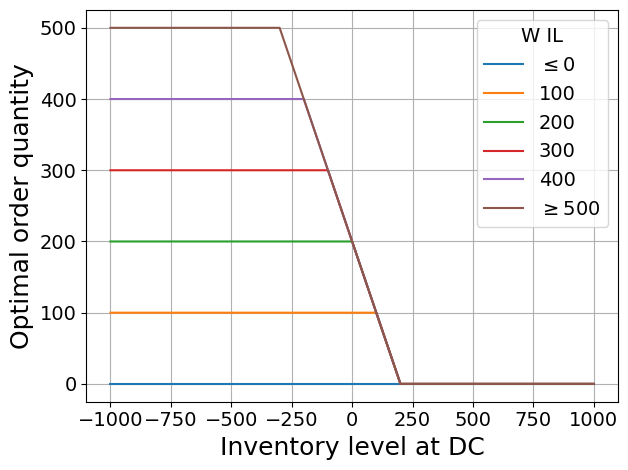

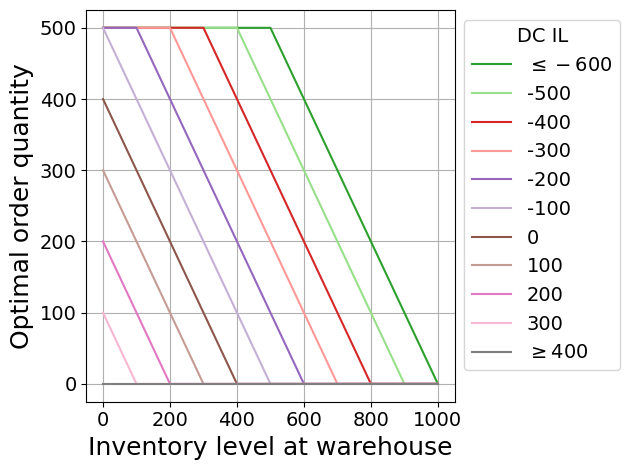

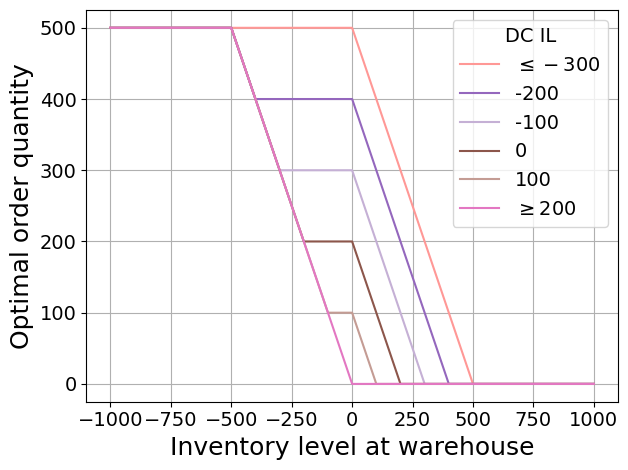

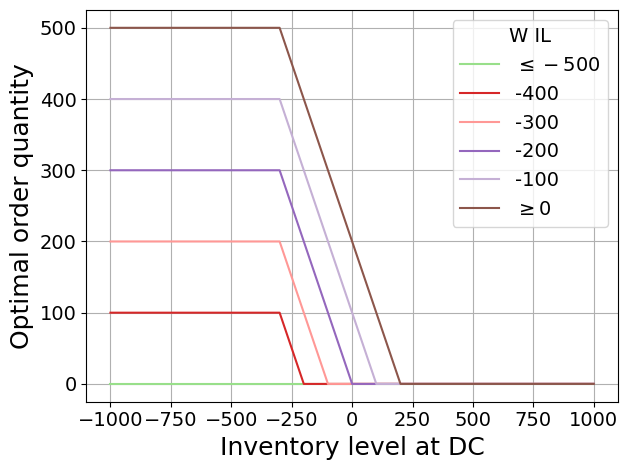

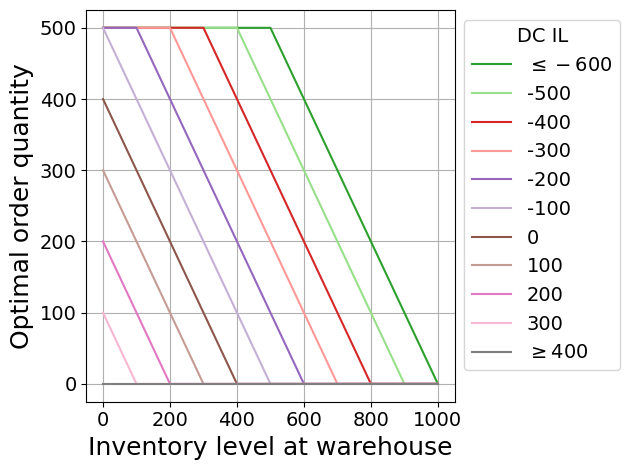

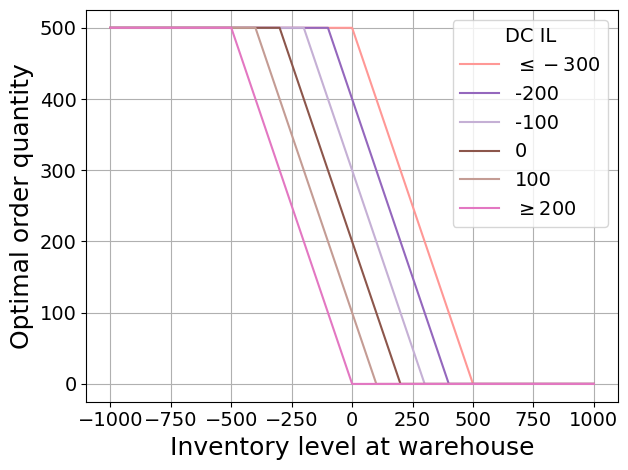

In [110]:
# Centralised dwoc
generate_policy_plot(c0_optimal_policy, lb=0, ub=500, colour_by="W")
generate_policy_plot(c0_optimal_policy, lb=-600, ub=400, colour_by="DC", bbox_to_anchor=(1,1))

# Centralised noc
generate_policy_plot(c0_noc_optimal_policy, lb=-300, ub=200, colour_by="DC", oc=False)
generate_policy_plot(c0_noc_optimal_policy, lb=-500, ub=0, colour_by="W", oc=False)

# Decentralised dwoc
generate_policy_plot(dc0_optimal_policy, system_type="decentralised", 
                     lb=-600, ub=400, colour_by="DC", bbox_to_anchor=(1,1))

# Decentralised noc
generate_policy_plot(dc0_noc_optimal_policy, system_type="decentralised",
                     lb=-300, ub=200, colour_by="DC", oc=False)

    






Comparing costs of centralised (dash) and decentralised (dot) problem with ordering constraint


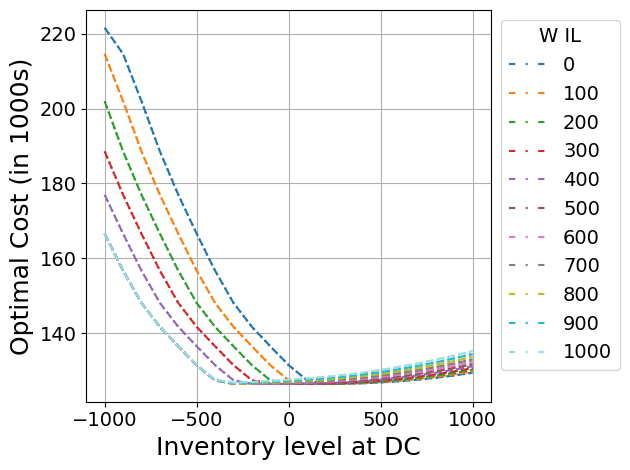

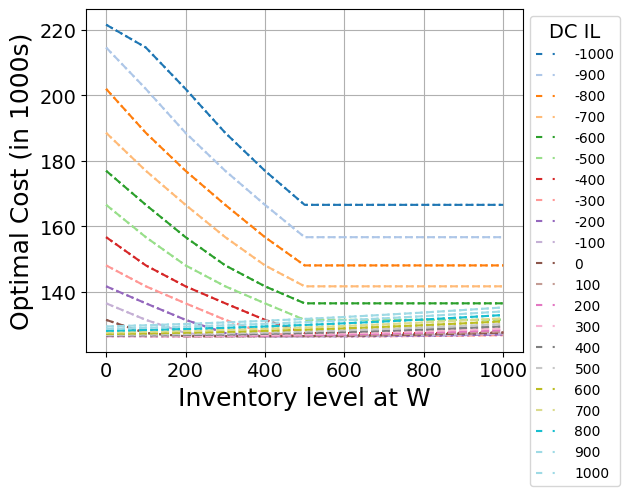






Comparing costs of centralised (dash) and decentralised (dot) problem without ordering constraint


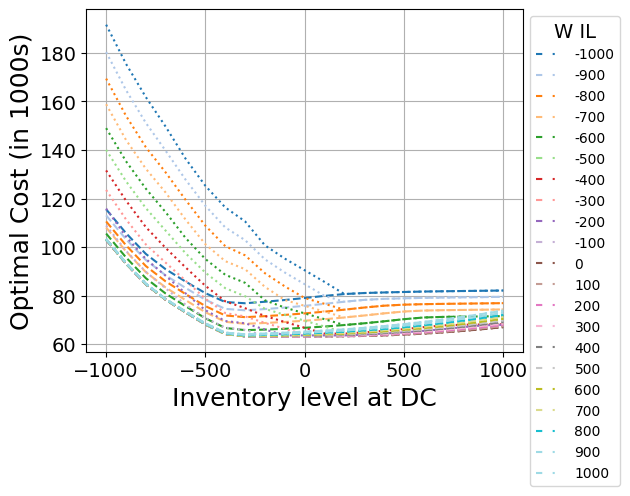

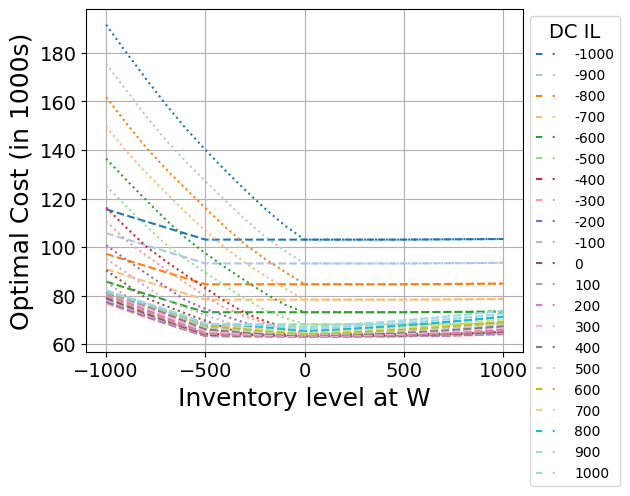






Comparing costs of centralised problems with (dot) and without (dash) ordering constraint


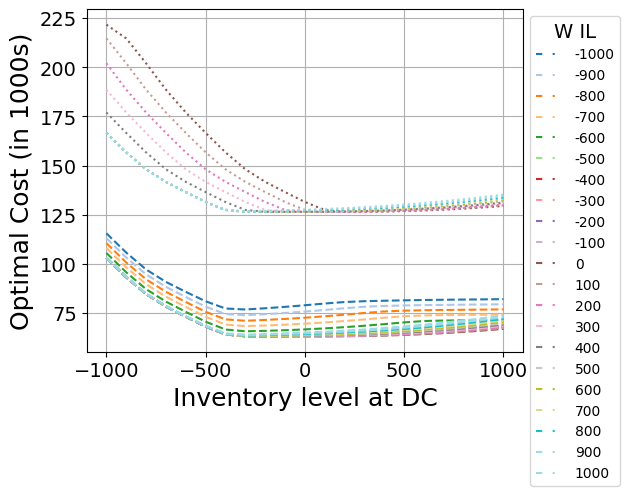

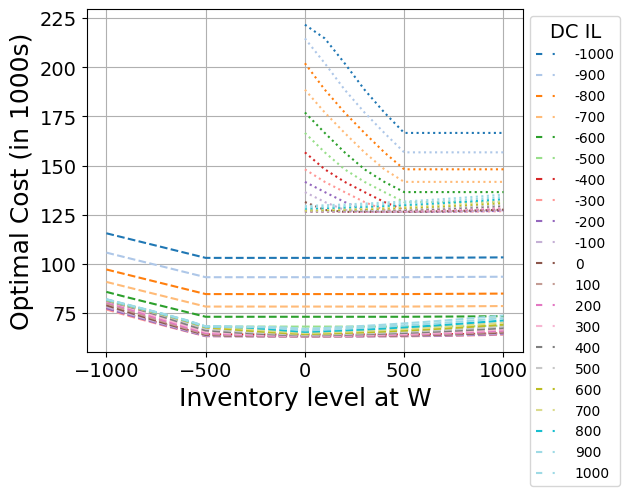






Comparing costs of decentralised problems with (dot) and without (dash) ordering constraint


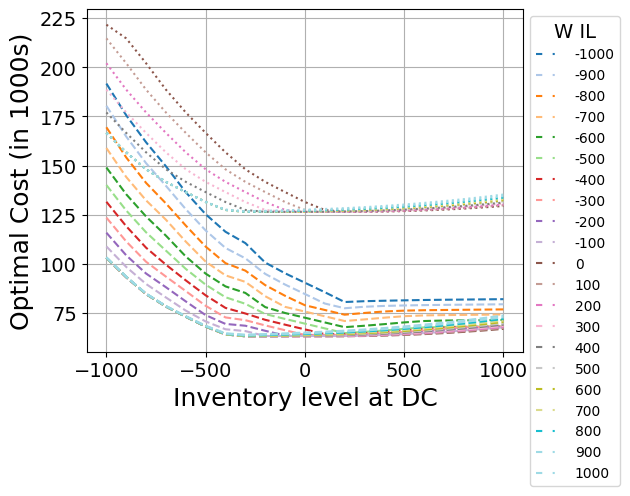

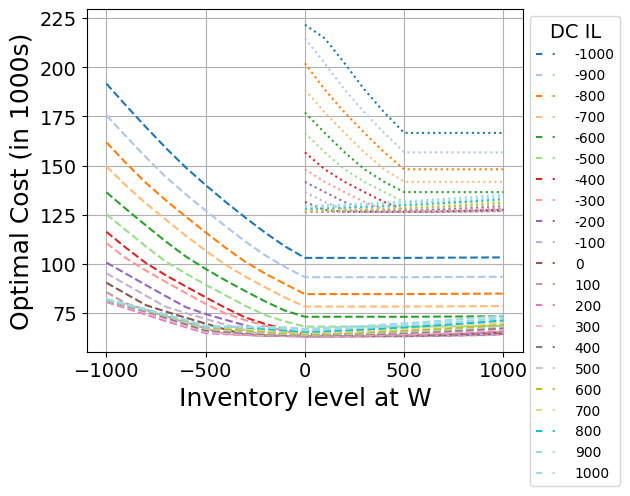

In [111]:
print("Comparing costs of centralised (dash) and decentralised (dot) problem with ordering constraint")
two_cost_plot(c0_cost_function, dc0_cost_function, cost_names=['c0_dwoc', 'dc0_dwoc'])
two_cost_plot(c0_cost_function, dc0_cost_function, cost_names=['c0_dwoc', 'dc0_dwoc'], colour_by="DC")

print("\n\n\n\n\nComparing costs of centralised (dash) and decentralised (dot) problem without ordering constraint")
two_cost_plot(c0_noc_cost_function, dc0_noc_cost_function, cost_names=['c0_noc', 'dc0_noc'])
two_cost_plot(c0_noc_cost_function, dc0_noc_cost_function, cost_names=['c0_noc', 'dc0_noc'], colour_by="DC")

print("\n\n\n\n\nComparing costs of centralised problems with (dot) and without (dash) ordering constraint")
two_cost_plot(c0_noc_cost_function, c0_cost_function, cost_names=['c0_noc', 'c0_dwoc'])
two_cost_plot(c0_noc_cost_function, c0_cost_function, cost_names=['c0_noc', 'c0_dwoc'], colour_by="DC")

print("\n\n\n\n\nComparing costs of decentralised problems with (dot) and without (dash) ordering constraint")
two_cost_plot(dc0_noc_cost_function, dc0_cost_function, cost_names=['dc0_noc', 'dc0_dwoc'])
two_cost_plot(dc0_noc_cost_function, dc0_cost_function, cost_names=['dc0_noc', 'dc0_dwoc'], colour_by="DC")





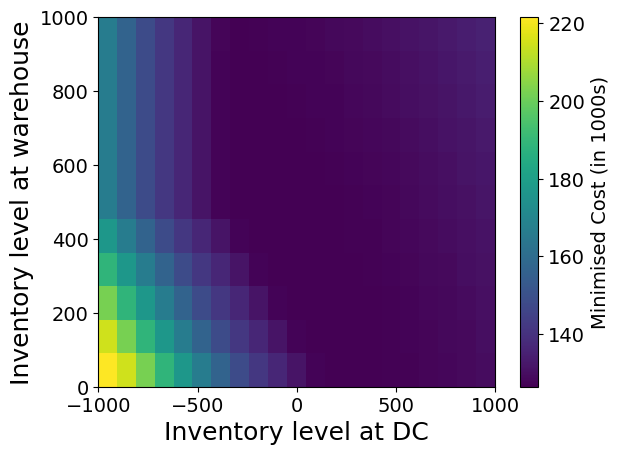

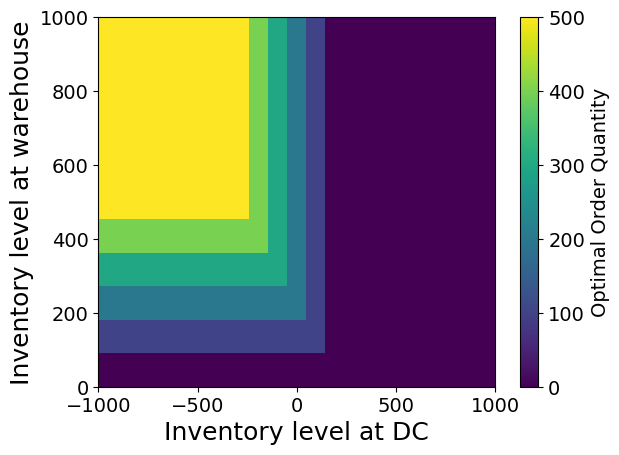

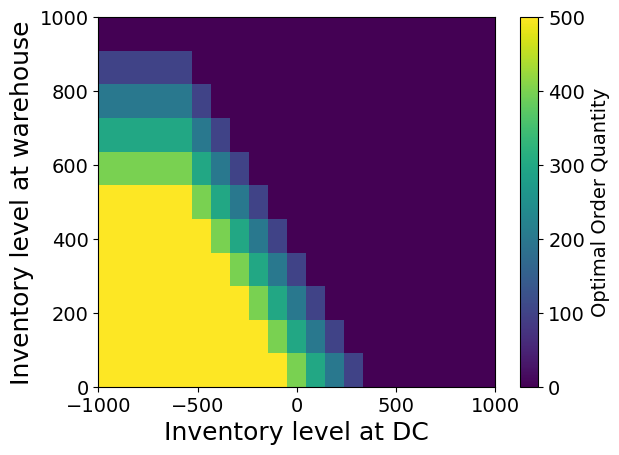

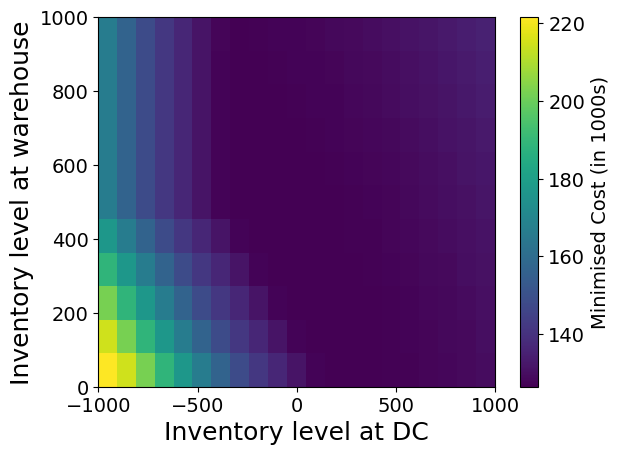

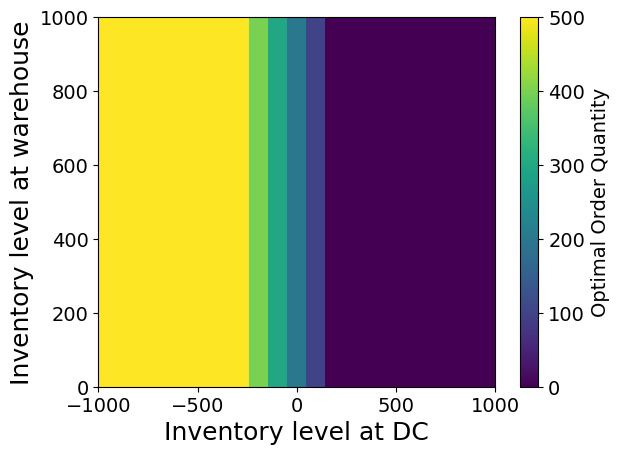

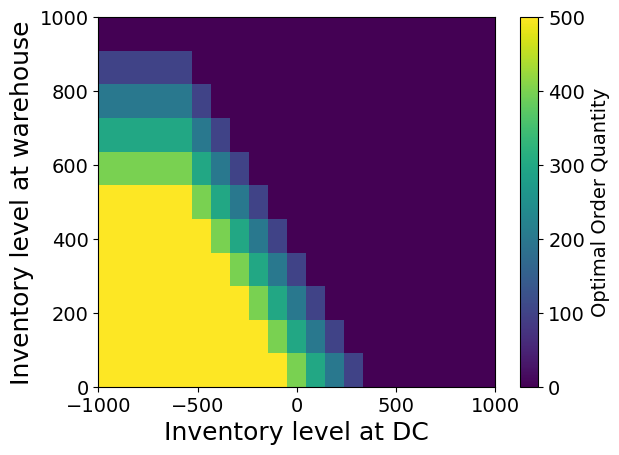

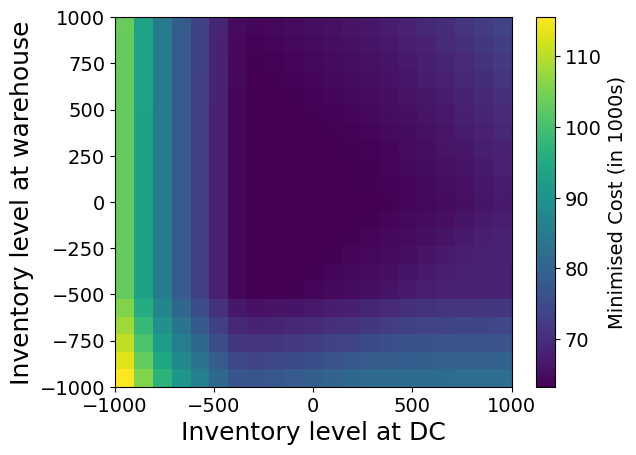

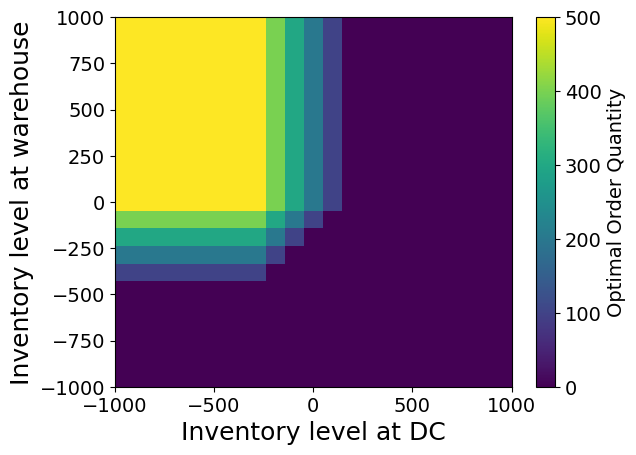

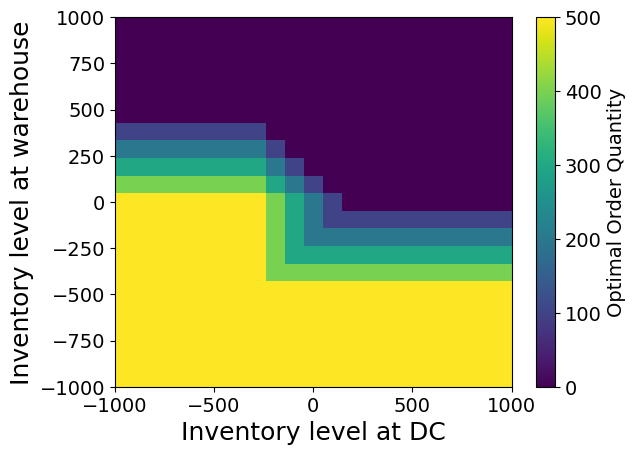

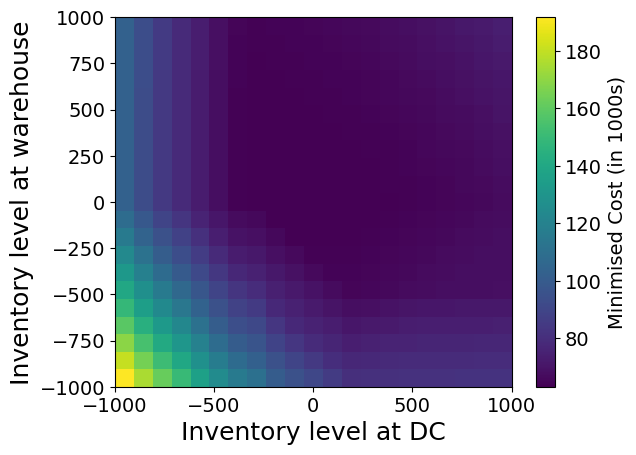

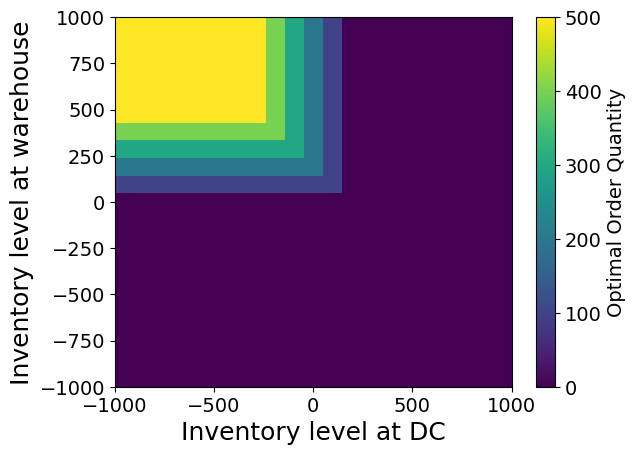

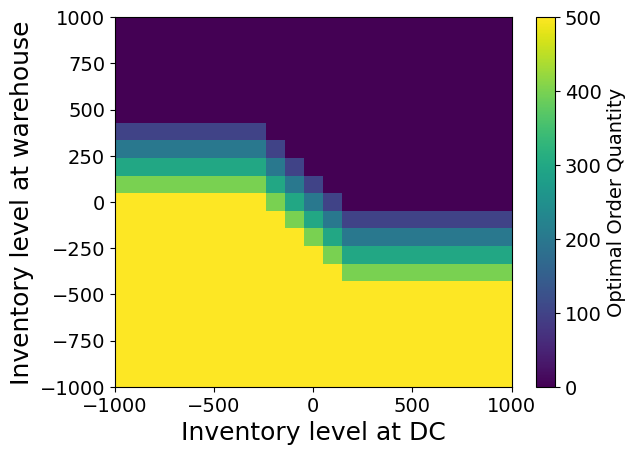

In [59]:
# Centralised dwoc
generate_heatmap_2ech(c0_cost_function, "cost", "centralised", oc=True)
generate_heatmap_2ech(c0_optimal_policy, "dc_policy", "centralised", oc=True)
generate_heatmap_2ech(c0_optimal_policy, "w_policy", "centralised", oc=True)

# Decentralised dwoc
generate_heatmap_2ech(dc0_cost_function, "cost", "decentralised", S1=200, Q1_max=500, oc=True)
generate_heatmap_2ech(dc0_optimal_policy, "dc_policy", "decentralised", S1=200, Q1_max=500, oc=True)
generate_heatmap_2ech(dc0_optimal_policy, "w_policy", "decentralised", S1=200, Q1_max=500, oc=True)


# Centralised noc
generate_heatmap_2ech(c0_noc_cost_function, "cost", "centralised", oc=False)
generate_heatmap_2ech(c0_noc_optimal_policy, "dc_policy", "centralised", oc=False)
generate_heatmap_2ech(c0_noc_optimal_policy, "w_policy", "centralised", oc=False)

# Decentralised noc
generate_heatmap_2ech(dc0_noc_cost_function, "cost", "decentralised", S1=200, Q1_max=500, oc=False)
generate_heatmap_2ech(dc0_noc_optimal_policy, "dc_policy", "decentralised", S1=200, Q1_max=500, oc=False)
generate_heatmap_2ech(dc0_noc_optimal_policy, "w_policy", "decentralised", S1=200, Q1_max=500, oc=False)

In [60]:
# generate_cost_plot(c0_noc_cost_function)
# generate_cost_plot(c0_noc_cost_function, colour_by="DC")
# generate_policy_plot(c0_noc_optimal_policy, system_type="centralised", lb=-500, ub=0, colour_by="W")
# generate_policy_plot(c0_noc_optimal_policy, system_type="centralised", lb=-300, ub=200, colour_by="DC", bbox_to_anchor=(1,1))


# generate_heatmap_2ech(c0_noc_cost_function, "cost", "centralised", oc=False)
# generate_heatmap_2ech(c0_noc_optimal_policy, "dc_policy", "centralised", oc=False)
# generate_heatmap_2ech(c0_noc_optimal_policy, "w_policy", "centralised", oc=False)

In [61]:
# generate_cost_plot(dc0_noc_cost_function)
# generate_cost_plot(dc0_noc_cost_function, colour_by="DC")
# generate_policy_plot(dc0_noc_optimal_policy, system_type="decentralised", lb=-300, ub=200, colour_by="DC", bbox_to_anchor=(1,1))


# generate_heatmap_2ech(dc0_noc_cost_function, "cost", "decentralised", S1=200, Q1_max=500, oc=True)
# generate_heatmap_2ech(dc0_noc_optimal_policy, "dc_policy", "decentralised", S1=200, Q1_max=500, oc=True)
# generate_heatmap_2ech(dc0_noc_optimal_policy, "w_policy", "decentralised", S1=200, Q1_max=500, oc=True)

# Make pandas .csv files for data

In [62]:
# Convert dictionary to DataFrame
c0_cost_df = pd.Series(c0_cost_function).unstack(level=0)
dc0_cost_df = pd.Series(dc0_cost_function).unstack(level=0)
c0_noc_cost_df = pd.Series(c0_noc_cost_function).unstack(level=0)
dc0_noc_cost_df = pd.Series(dc0_noc_cost_function).unstack(level=0)


# Export to CSV
c0_cost_df.to_csv('tables/centralised_oc_costs.csv')
dc0_cost_df.to_csv('tables/decentralised_oc_costs.csv')
c0_noc_cost_df.to_csv('tables/centralised_noc_costs.csv')
dc0_noc_cost_df.to_csv('tables/decentralised_noc_costs.csv')